In [2]:
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
class FiniteHorizon:

    def __init__(self, A, B, C, P, Q, R, N, umax=np.inf, ymax=np.inf, terminal=False):

        n, m = B.shape
        
        # Setting up the optimization variables
        self.U = cp.Variable((m, N)) # [ u_0, ..., u_{N-1} ]
        self.X = cp.Variable((n, N+1)) # [ x_0, ..., x_N ]
        self.x0 = cp.Parameter(n) # Placeholder for the initial state; it is set when calling solve.
        
        # Setting up the finite-horizon criterion
        criterion = cp.quad_form(self.X[:, N], P)
        for k in range(N):
            criterion += cp.quad_form(self.X[:, k], Q)+cp.quad_form( self.U[:, k], R)

        self.criteron = criterion
        
        # Setting up constraints
        constraints = []
        constraints.append( self.X[:, 0] == self.x0 ) # x0 == x(0)
        constraints.append( self.X[:, 1:N+1] == A@self.X[:, 0:N] + B@self.U ) # x_{k+1} = A x_k + B u_k, k=0, ..., N-1

        if (umax < np.inf):
            constraints.append( cp.abs(self.U) - umax  <= 0 ) # |u_k| <= umax

        if (ymax < np.inf):
                constraints.append( cp.abs(C@self.X) -ymax <= 0) 

        if (terminal):
            constraints.append( self.X[:,N] == 0 ) # X_N == 0
        
        # Minimization problem
        self.prob = cp.Problem(cp.Minimize(criterion),constraints)

    def solve(self, x0, verbose=False):
        self.x0.value = x0.flatten()
        self.prob.solve(verbose=verbose, solver = cp.CLARABEL)

        return self.U.value, self.X.value

In [4]:
class LTI:
    def __init__(self, A, B, x0, umax=np.inf):
        self.A = A  #A
        self.B = B #B
        self.n, self.m = B.shape  #n,m. Dimension of B
        self.umax = umax #U_max
        x0 = x0.reshape(self.n,1)
        self.X = x0
        self.U = np.empty((self.m,0)) 

    def step(self, u):
        # Imposte consraints on the input
        u = u.reshape(self.m,1)
        u[u>self.umax] = self.umax #Umax = inf --> infinite Horizon
        u[u<-self.umax] = -self.umax #????

        # Take one step
        x = self.A@self.X[:,[-1]] + self.B@u 
        self.X = np.append(self.X, x, axis=1)
        self.U = np.append(self.U, u, axis=1)
        return self.X[:, [-1]]

Consider the system
$$
\begin{aligned}
x(t+1) &= \begin{bmatrix} 1.5 & 1 \\ 0 & 0.5 \end{bmatrix} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} u(t) \\
y(t)&= \begin{bmatrix} 0.5 & 0.5 \end{bmatrix} x(t)
\end{aligned}
$$
(a) Is the system asympototically stable?

In [5]:
A = np.array([[1.5, 1], [0, 0.5]])
B = np.array([ [1], [0]])
C = np.array([0.5, 0.5])
#x0 = np.array([ [-10], [-10] ])
#umax=0.2

#Stability of system
poles = np.linalg.eig(A)[0]
print("Poles:", poles)
#System is unstablem, one pole is outside of unit-circle

Poles: [1.5 0.5]


At least on of the poles are larger than 1, and thus the system is not asymptotically stable.


(b) Find the feedback $$u(t) = -Lx(t)$$ that corresponds to using unconstrained MPC with criterion 
$$
J_{\infty}(x_0)= \sum_{k=0}^{\infty} x_k^T Q x_k + u_k^T R u_k
$$

with $Q=I$, $R=1$. What is the smallest  N that maked the closed-loop system stable? Find L for $N=2$

Numerical calculation of L have stabilized at:  16
MPC: L0= [[1.08679955 0.91320045]] . Closed-loop poles:  [0.41320045 0.5       ]
LQR, L=  [[1.08679955 0.91320045]] Closed-loop poles:  [0.41320045 0.5       ]


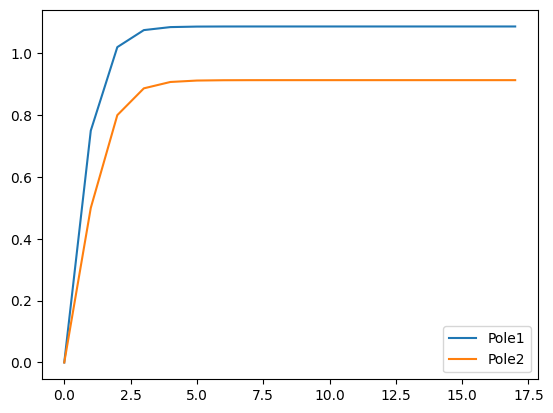

In [80]:
Q = np.eye(2)
R = np.ones((1,1)) 
termination_val = 1e-10

PN = np.zeros((2,2))
#PN = 10*np.eye(2)ls
N = 100

# Compute P_{N-1}, ..., P_{1}
P = PN

#L0_last = np.ndarray(shape=(2,1),dtype=float)
L0_last = np.array([[0,0]])
L_pole1 = [0]
L_pole2 = [0]
for j in range(N-1):
    P = A.T@P@A + Q - A.T@P@B@np.linalg.inv(B.T@P@B + R)@B.T@P@A
    L0 = np.linalg.inv(B.T@P@B + R)@B.T@P@A
    L_pole1.append(L0[0][0])
    L_pole2.append(L0[0][1])
    #Check if analytical value of poles have stabilized
    if ((np.abs(L0[0][0]-L0_last[0][0]) < termination_val) and ((np.abs(L0[0][1]-L0_last[0][1])) < termination_val)):
        print("Numerical calculation of L have stabilized at: ", j)
        break
    L0_last = L0

L_plot = np.array(L_pole2)
# Infinite horizon feedback
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

print("MPC: L0=", L0,". Closed-loop poles: ", np.linalg.eig(A-B@L0)[0])
print("LQR, L= ", L, "Closed-loop poles: ", np.linalg.eig(A-B@L)[0])

plt.figure()
plt.plot(L_pole1, label="Pole1")
plt.plot(L_pole2, label="Pole2")
plt.legend()

We are numerically finding the penalty (feedback?) $P_j$ which is sufficient to make the system stable. We can see that the numerical solution of $L_0$ stabilizes at iteration $16$, and at that point we get the same pole values as for the analytical solution. 

(c) Consider 
$$
J_{\infty} = \sum_{k=0}^{\infty} x_k^TQx_k + u_k^TRu_k
$$

$Q=I$, $R=1$. Use the optimal infinite-horizon feedback $u(t)= -Lx(t)$, anxd $ x(0)=\begin{bmatrix} 0 \\ 1 \end{bmatrix}$, what is the value of $J_{\infty}^* (x(0))$? $\newline$
Solve it with:


1. Optimal cost is given by $J_\infty(x(0)) = x^T(0)P_{\infty}x(0)$.

In [74]:
#Intial values
x_0=np.array([0,1])

# Infinite horizon feedback
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

J = x_0.T@Pinf@x_0
print("analytical cost: ", J)

analytical cost:  2.630199322349037


2. With the optimal finite horizon $L_0$ where the system is stable and $x(t) \rightarrow 0$. 

Stable at iteration: 18 .With a termination value of: 1e-10


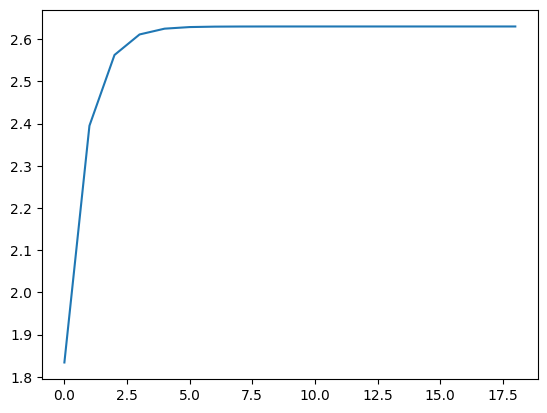

In [75]:
sys = LTI(A,B,x_0)
x = x_0
k = 100
termination_val = 1e-10
j = 0
j_last = 0
j_plot = []
for t in range(k):
    u = -L0@x
    j_cost=x.T@Q@x + u.T@R@u
    #Cast cost to scalar value
    j+=j_cost.item()
    j_plot.append(j)
    if np.abs(j_last-j)<termination_val:
        print("Stable at iteration:", t, ".With a termination value of:", termination_val)
        break
    j_last = j
    x = sys.step(u)

j_plot = np.array(j_plot)

plt.figure()
plt.plot(j_plot)

2. 
Consider 
$$
J_{K} = \sum x^TQx + u^TRu
$$
with $K=1,3,50,100,..$


In [ ]:
A=2
B=1
C=0.5

x0=0

In [27]:
Q = 1
R = 1
termination_val = 1e-10

PN = np.zeros((2,2))
#PN = 10*np.eye(2)ls
N = 100

# Compute P_{N-1}, ..., P_{1}
P = PN

#L0_last = np.ndarray(shape=(2,1),dtype=float)
L0_last = 0
L_pole = [0]
for j in range(N-1):
    P = A**2 * P + Q - A * B * P ** (B**2 * P)
    P = A.T@P@A + Q - A.T@P@B@np.linalg.inv(B.T@P@B + R)@B.T@P@A
    L0 = np.linalg.inv(B.T@P@B + R)@B.T@P@A
    L_pole.append(L0)
    #Check if analytical value of poles have stabilized
    if ((np.abs(L0[0][0]-L0_last[0][0]) < termination_val) and ((np.abs(L0[0][1]-L0_last[0][1])) < termination_val)):
        print("Numerical calculation of L have stabilized at: ", j)
        break
    L0_last = L0

L_plot = np.array(L_pole2)
# Infinite horizon feedback
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

print("MPC: L0=", L0,". Closed-loop poles: ", np.linalg.eig(A-B@L0)[0])
print("LQR, L= ", L, "Closed-loop poles: ", np.linalg.eig(A-B@L)[0])

plt.figure()
plt.plot(L_pole1, label="Pole1")
plt.plot(L_pole2, label="Pole2")
plt.legend()

MPC: L0= [[1.08679955 0.91320045]] . Closed-loop poles:  [0.41320045 0.5       ]
LQR:  L= [[1.08679955 0.91320045]] . Closed-loop poles:  [0.41320045 0.5       ]
